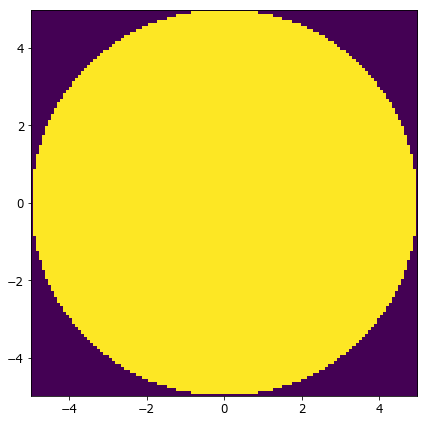

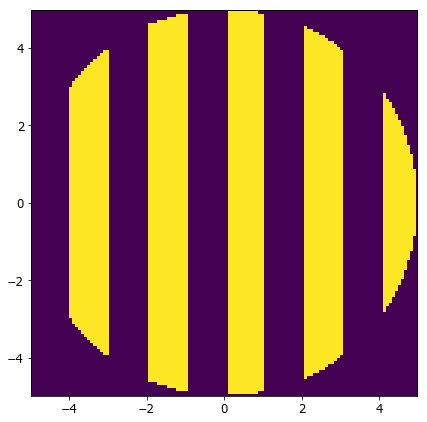

In [1]:
from hcipy import *
import numpy as np
from matplotlib import pyplot as plt

def aberrate(aperture, N, input_grid, f=1):
    wf = Wavefront(aperture(input_grid))
    return aberrate_wf(N, wf, f)

def aberrate_wf(N, wf, f): #apply sine wave across the input wavefront
    shaped_field = wf.electric_field
    shaped_field.shape = (N, N)
    aslist = np.asarray(shaped_field).tolist()
    for rownum, row in enumerate(aslist):
        for colnum, el in enumerate(row):
            aslist[rownum][colnum] = el * np.sin(colnum * 2 * f * np.pi / N)
    wf.electric_field = Field(np.asarray(aslist).ravel(), wf.electric_field.grid)
    return wf

N = 128
padding = 1 # zero-padding on pyramid output. 1 means sub-pupil images touch the outside edges

D_keck = 9.96
keck_aperture = circular_aperture(D_keck) 
# I also implemented a better make_keck_aperture, this is just for simplicity when testing
pupil_grid = make_pupil_grid(N, D_keck * padding)
aberrated = aberrate(keck_aperture, N, pupil_grid, 5 * padding)
imshow_field(keck_aperture(pupil_grid))
plt.show()
imshow_field(keck_aperture(pupil_grid) * aberrated.phase)
plt.show()

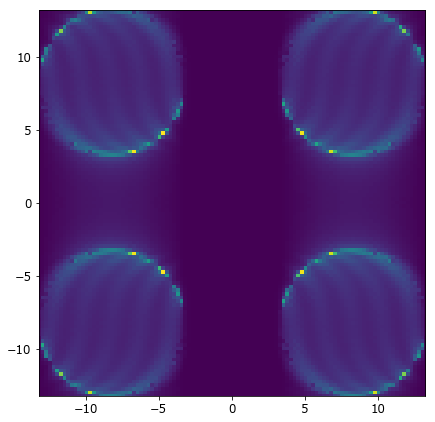

In [2]:
sps = 40 #sub-pupil size
pupsep = 65/39.3
outgrid_size = int(np.ceil(sps * (pupsep + 1)))
keck_pyramid = PyramidWavefrontSensorOptics(pupil_grid, pupil_separation=pupsep, num_pupil_pixels=sps)
pyramid_grid = make_pupil_grid(N, 3.6e-3)
pyramid_output = keck_pyramid.forward(aberrated).intensity
imshow_field(pyramid_output)
plt.show()

/Users/adityasengupta/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


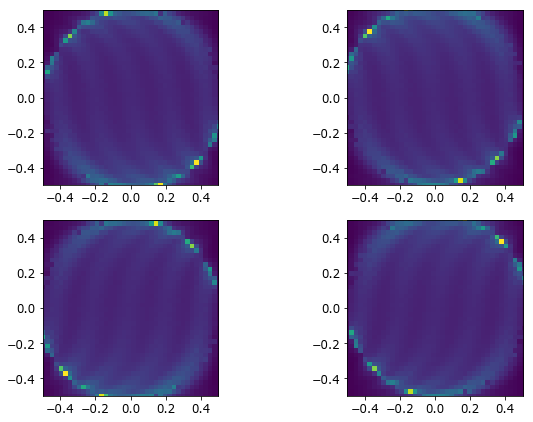

In [12]:
outgrid = np.zeros((N, N)).tolist()
pyramid_output.shape = (outgrid_size, outgrid_size)
buffer = (N - outgrid_size)//2
# added ability to get sub-pupil images that are separated. Default PWFSOptics has pupil separation = 1.5 but 
# image extraction assumes separation = 1. Not sure, but this may have caused errors before.
for rownum, row in enumerate(pyramid_output.tolist()):
    for colnum, el in enumerate(row):
        outgrid[rownum+buffer][colnum+buffer] = el
images = Field(np.asarray(outgrid).ravel(), pyramid_grid)
image = images.shaped
sub_images = [image[buffer:sps+buffer, buffer:sps+buffer], 
              image[(N-buffer-sps-1):(N-buffer-1), buffer:sps+buffer],
              image[buffer:sps+buffer, (N-buffer-sps-1):(N-buffer-1)], 
              image[(N-buffer-sps-1):(N-buffer-1), (N-buffer-sps-1):(N-buffer-1)]]
subimage_grid = make_pupil_grid(sps)
for count, img in enumerate(sub_images):
    img = img.ravel()
    img.grid = subimage_grid
    sub_images[count] = img
    imshow_field(img)
    plt.subplot(2,2,count+1)
plt.show()
# This slightly crops some of the edges of the sub-pupil images, but it is the actual size we'll have to work with.
# Hopefully no significant information loss because of this. (Maybe off by one?)

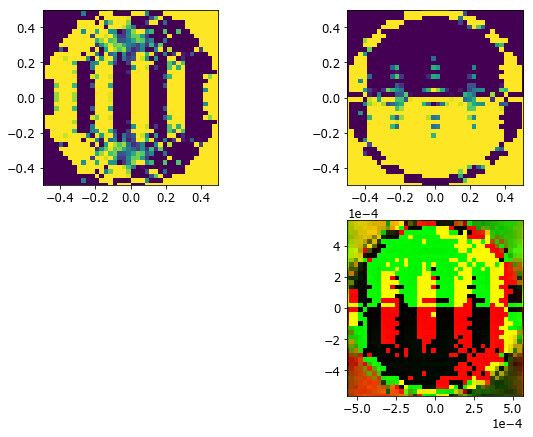

In [23]:
def estimate(EstimatorObject, images_list):
    '''
    Slightly edited version of the PWFSEstimator.estimate function. The earlier function had a difference in sub-pupil
    numbering compared to the literature I found. As implemented before, it was 
    a b
    c d
    but according to papers such as https://ui.adsabs.harvard.edu/#abs/2006OExpr..1411925B/abstract (page 3) it's
    b a
    c d
    '''
    I_b = images_list[0]
    I_a = images_list[1]
    I_c = images_list[2]
    I_d = images_list[3]
    norm = I_a + I_b + I_c + I_d
    I_x = (I_a + I_b - I_c - I_d) / norm
    I_y = (I_a - I_b - I_c + I_d) / norm
    dummy = Field(np.zeros(I_x.size), I_x.grid)
    I_x = I_x.ravel()
    I_y = I_y.ravel()
    dummy = dummy.ravel()
    res = Field([I_x, I_y, dummy], EstimatorObject.pupil_mask.grid)
    # previously, was not possible to plot res, can now do so as a red-green plot (red = x and green = y).
    return res, I_x, I_y

pyramid_subgrid = make_pupil_grid(sps*2, (3.6e-3)*sps*2/N)
keck_pyramid_estimator = PyramidWavefrontSensorEstimator(keck_aperture, pyramid_subgrid)
aberratedslopes, x_slopes, y_slopes = estimate(keck_pyramid_estimator, sub_images)
plt.subplot(2,2,1)
imshow_field(x_slopes, vmax=0.005, vmin=-0.005) # estimate output is quite small, can't see differences easily
plt.subplot(2,2,2)
imshow_field(y_slopes, vmax=0.005, vmin=-0.005)
plt.subplot(2,2,4)
imshow_field(aberratedslopes, vmax=0.005, vmin=-0.005)
plt.show()
